In [1]:
%pylab
%run FastFlowNets.py 64 1 0
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using matplotlib backend: <object object at 0x7f3d3007eee0>
Populating the interactive namespace from numpy and matplotlib


# Run power-efficient Coupled Learning with multiple values of lambda

In [ ]:
trials = 5
nTasks = 1
Steps = 100000


num = 400
CompSteps = asarray(unique(around(r_[0, logspace(0, log10(Steps-1), num)])), int)
nComp = len(CompSteps)


alpha = 0.5
eta = 1.e-3

# Lambdas
nL = 17
Ls = logspace(-10, -2, nL)
Ls = r_[0., Ls]
nL = len(Ls)

lth = 1.e-4

GroundNodes = array([NN-1])

sources = 2
targets = 2

TrainSize = 20
TestSize = 100
OutSize = 100

ACostsTr = zeros([trials, nL, nComp])
ACostsTe = zeros([trials, nL, nComp])
ACostsOu = zeros([trials, nL, nComp])
APowersTr = zeros([trials, nL, nComp])
APowersTe = zeros([trials, nL, nComp])
APowersOu = zeros([trials, nL, nComp])
ANDKL = zeros([trials, nL, nComp])
AIPowersTr = zeros([trials, nL])
AIPowersTe = zeros([trials, nL])
AIPowersOu = zeros([trials, nL])
ANES = zeros([trials])
ADMS = []
AEndK = zeros([trials, nL, NE])


ACoeffs = zeros([trials, sources, targets])
AREdges = zeros([trials, sources+targets])
ATrainData = zeros([trials, sources, TrainSize])
ATrainComp = zeros([trials, targets, TrainSize])
ATestData = zeros([trials, sources, TestSize])
ATestComp = zeros([trials, targets, TestSize])
AOutData = zeros([trials, sources, OutSize])
AOutComp = zeros([trials, targets, OutSize])

noise = 0
k0 = 1.e0

for t in range(trials):
    # setup cofficients matrix and training and test sets
    Coeffs = array([[0.2,0.3],[0.1,0.5]])
    if t > 0:
        Coeffs = Coeffs + randn(2,2)*0.1
    ACoeffs[t] = Coeffs
    
    REdges = choice(range(0,NE), size=4, replace=False)
    SourceEdges = REdges[:2]
    TargetEdges = REdges[2:]
    GroundNodes = [NN-1]
    AREdges[t] = REdges
 
    TrainData = rand.rand(2,TrainSize) * 1.0 + 0.0
    TrainComp = array([Coeffs[0,0]*TrainData[0] + Coeffs[0,1]*TrainData[1] , Coeffs[1,0]*TrainData[0] + Coeffs[1,1]*TrainData[1]])
    TrainComp += randn(2,TrainSize) * noise
    M1 = mean(TrainComp, 1)
    ATrainData[t] = TrainData
    ATrainComp[t] = TrainComp

    TestData = rand.rand(2,TestSize) * 1.0 + 0.0
    TestComp = array([Coeffs[0,0]*TestData[0] + Coeffs[0,1]*TestData[1] , Coeffs[1,0]*TestData[0] + Coeffs[1,1]*TestData[1]])
    TestComp += randn(2,TestSize) * noise
    M2 = mean(TestComp, 1)
    ATestData[t] = TestData
    ATestComp[t] = TestComp
    
    OutData = rand.randn(2,OutSize)
    OutComp = array([Coeffs[0,0]*OutData[0] + Coeffs[0,1]*OutData[1] , Coeffs[1,0]*OutData[0] + Coeffs[1,1]*OutData[1]])
    OutComp += randn(2,OutSize) * noise
    MO = mean(OutComp, 1)
    AOutData[t] = OutData
    AOutComp[t] = OutComp

    ANES[t] = NE
    ADMS.append(DM)

    EdgeList = REdges
    KEdges = array(list(set(arange(NE)) - set(EdgeList)))
    
    Edges = array(EdgeList[:sources])
    EdgeData = TestData[:,0]
    OutEdges = array(EdgeList[sources:])
    OutEdgesVals = TestComp[:,0]
    
    Cstr = ConstraintMatrix([], [], EdgeData, Edges, GroundNodes, NN, EI, EJ)[:,:-1]
    Comp = ConstraintMatrix([], [], OutEdgesVals, OutEdges, [], NN, EI, EJ)[:,:-1]

    LF = zeros([NN + len(Cstr), NN + len(Cstr)])
    LC = zeros([NN + len(Cstr) + len(Comp), NN + len(Cstr) + len(Comp)])
    LF[NN:,:NN] = Cstr
    LF[:NN,NN:] = Cstr.T
    CC = vstack((Cstr, Comp))
    LC[NN:,:NN] = CC
    LC[:NN,NN:] = CC.T
    
    DLF = zeros_like(LF)
    DLC = zeros_like(LC)
    
    for lt in range(nL):
        Lam = Ls[lt]
        
        c = 0
        #KCL = ones(NE)
        KCL = ones(NE)*k0
        
        
        KOld = KCL.copy()
        
        
        # Hessians
        L = dot(KCL*DM.T, DM)
        LF[:NN,:NN] = L
        LC[:NN,:NN] = L
        # Inverse matrices
        ILF = inv(LF)
        ILC = inv(LC)
        
        # Training free states
        PF = ILF.dot(vstack((zeros([NN+1, TrainSize]), TrainData)))
        # Training pressure drops
        DPF = DM.dot(PF[:NN])
        # Cost function
        C0Tr = sum((DPF[OutEdges] - TrainComp)**2)/TrainSize
        ACostsTr[t,lt,c] = 1.
        
        # Trainig clamped states
        Nudge = DPF[OutEdges] + eta*(TrainComp - DPF[OutEdges])
        PC = ILC.dot(vstack((zeros([NN+1, TrainSize]), TrainData, Nudge)))
        DPC = DM.dot(PC[:NN])
        DKCL = alpha/eta * mean(DPC**2. - DPF**2, axis=1)
        
        # Training set power
        Power0Tr = 0.5*sum(KCL*DPF.T**2.)/TrainSize
        APowersTr[t,lt,c] = Power0Tr
        
        # Test free states
        PF = ILF.dot(vstack((zeros([NN+1, TestSize]), TestData)))
        # Test pressure drops
        DPF = DM.dot(PF[:NN])
        # Cost function
        C0Te = sum((DPF[OutEdges] - TestComp)**2)/TestSize
        ACostsTe[t,lt,c] = 1.
        
        # Test set power
        Power0Te = 0.5*sum(KCL*DPF.T**2.)/TestSize
        APowersTe[t,lt,c] = Power0Te
        
        # Out free states
        PF = ILF.dot(vstack((zeros([NN+1, OutSize]), OutData)))
        # Test pressure drops
        DPF = DM.dot(PF[:NN])
        # Cost function
        C0Ou = sum((DPF[OutEdges] - OutComp)**2)/OutSize
        ACostsOu[t,lt,c] = 1.
        
        # Out set power
        Power0Ou = 0.5*sum(KCL*DPF.T**2.)/OutSize
        APowersOu[t,lt,c] = Power0Ou
        
        ANDKL[t,lt,c] = norm(KCL-KOld)
        
        print(t+1,Lam,c,1.,1.,Power0Tr, Power0Te)

        for i in range(1,Steps+1):
            if i in CompSteps:
                c = c + 1 
                
                # Training free state
                PF = ILF.dot(vstack((zeros([NN+1, TrainSize]), TrainData)))
                # Training pressure drops
                DPF = DM.dot(PF[:NN])
                # Cost function
                C = sum((DPF[OutEdges] - TrainComp)**2)/TrainSize
                ACostsTr[t,lt,c] = C/C0Tr
                # Training set power
                PowerTr = 0.5*sum(KCL*DPF.T**2.)/TrainSize
                APowersTr[t,lt,c] = PowerTr
                
                # Test free state
                PF = ILF.dot(vstack((zeros([NN+1, TestSize]), TestData)))
                # Test pressure drops
                DPF = DM.dot(PF[:NN])
                # Cost function
                C = sum((DPF[OutEdges] - TestComp)**2)/TestSize
                ACostsTe[t,lt,c] = C/C0Te
                # Test set power
                PowerTe = 0.5*sum(KCL*DPF.T**2.)/TestSize
                APowersTe[t,lt,c] = PowerTe
                
                # Out free states
                PF = ILF.dot(vstack((zeros([NN+1, OutSize]), OutData)))
                # Test pressure drops
                DPF = DM.dot(PF[:NN])
                # Cost function
                C = sum((DPF[OutEdges] - OutComp)**2)/OutSize
                ACostsOu[t,lt,c] = C/C0Ou
                # Out set power
                PowerOu = 0.5*sum(KCL*DPF.T**2.)/OutSize
                APowersOu[t,lt,c] = PowerOu
                
                ANDKL[t,lt,c] = norm(KCL-KOld)
                    
                

            # Coupled learning update
            # Training free states
            PF = ILF.dot(vstack((zeros([NN+1, TrainSize]), TrainData)))
            # Training pressure drops
            DPF = DM.dot(PF[:NN])
            # Trainig clamped states
            Nudge = DPF[OutEdges] + eta*(TrainComp - DPF[OutEdges])
            PC = ILC.dot(vstack((zeros([NN+1, TrainSize]), TrainData, Nudge)))
            DPC = DM.dot(PC[:NN])
            
            DKCL = alpha/eta * mean(DPC**2. - (1. - Lam) * DPF**2, axis=1)     #+ R * sum(DPF**2, axis=1)

            KOld = KCL.copy()
            KCL -= DKCL
            KCL = KCL.clip(lth,1.e6)
            
            #if (norm(DKCL) > 1.e-4) or (i%1000==0):
            if (norm(KCL-KOld) > 1.e-4) or (i%1000==0):
                # Hessians
                L = dot(KCL*DM.T, DM)
                LF[:NN,:NN] = L
                LC[:NN,:NN] = L
                # Inverse matrices
                ILF = inv(LF)
                ILC = inv(LC)
            else:
                # Quick inverse hessian trick
                dL = dot((KCL-KOld)*DM.T, DM)
                DLF[:NN,:NN] = dL
                DLC[:NN,:NN] = dL
                ILF = ILF - ILF.dot(DLF).dot(ILF)
                ILC = ILC - ILC.dot(DLC).dot(ILC)

            if i%10000==0:
                # Training free state
                PF = ILF.dot(vstack((zeros([NN+1, TrainSize]), TrainData)))
                # Training pressure drops
                DPF = DM.dot(PF[:NN])
                # Cost function
                CCL = sum((DPF[OutEdges] - TrainComp)**2)/TrainSize
                # Training set power
                PowerTr = 0.5*sum(KCL*DPF.T**2.)/TrainSize
                
                # Test free state
                PF = ILF.dot(vstack((zeros([NN+1, TestSize]), TestData)))
                # Test pressure drops
                DPF = DM.dot(PF[:NN])
                # Cost function
                CCL2 = sum((DPF[OutEdges] - TestComp)**2)/TestSize
                # Test set power
                PowerTe = 0.5*sum(KCL*DPF.T**2.)/TestSize
                
                print(t+1,Lam,i,CCL/C0Tr,PowerTr,norm(KCL-KOld))

        AEndK[t,lt,:NE] = KCL


    Save = {}
    Save['NN'] = NN
    Save['nTasks'] = nTasks
    Save['Ls'] = Ls
    Save['alpha'] = alpha
    Save['eta'] = eta
    Save['CompSteps'] = CompSteps
    Save['nComp'] = nComp
    Save['trials'] = trials
    Save['Steps'] = Steps
    Save['ANES'] = ANES
    Save['ADMS'] = ADMS
    Save['ACostsTr'] = ACostsTr
    Save['APowersTr'] = APowersTr
    Save['ACostsTe'] = ACostsTe
    Save['APowersTe'] = APowersTe
    Save['ACostsOu'] = ACostsOu
    Save['APowersOu'] = APowersOu
    Save['AEndK'] = AEndK
    Save['AREdges'] = AREdges
    Save['ACoeffs'] = ACoeffs
    Save['ATrainData'] = ATrainData
    Save['ATrainComp'] = ATrainComp
    Save['ATestData'] = ATestData
    Save['ATestComp'] = ATestComp
    Save['AOutData'] = AOutData
    Save['AOutComp'] = AOutComp
    Save['ANDKL'] = ANDKL
    Save['noise'] = noise
    Save['k0'] = k0

    import pickle
    fst = 'Regression64.pkl'
    f = open(fst, 'wb')
    pickle.dump(Save, f)
    f.close()
            

In [5]:
import pickle
fst = 'Regression64.pkl'
f = open(fst, 'rb')
Save = pickle.load(f)
f.close()

NN = Save['NN']
nTasks = Save['nTasks']
Ls = Save['Ls']
alpha = Save['alpha']
eta = Save['eta']
CompSteps = Save['CompSteps']
nComp = Save['nComp']
trials = Save['trials']
Steps = Save['Steps']
ANES = Save['ANES']
ADMS = Save['ADMS']
ACostsTr = Save['ACostsTr']
APowersTr = Save['APowersTr']
ACostsTe = Save['ACostsTe']
APowersTe = Save['APowersTe']
ACostsOu = Save['ACostsOu']
APowersOu = Save['APowersOu']
AEndK = Save['AEndK']
AREdges = Save['AREdges']
ACoeffs = Save['ACoeffs']
ATrainData = Save['ATrainData']
ATrainComp = Save['ATrainComp']
ATestData = Save['ATestData']
ATestComp = Save['ATestComp']
AOutData = Save['AOutData']
AOutComp = Save['AOutComp']
ANDKL = Save['ANDKL']

(array([1.e-17, 1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03,
        1.e-01, 1.e+01, 1.e+03]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

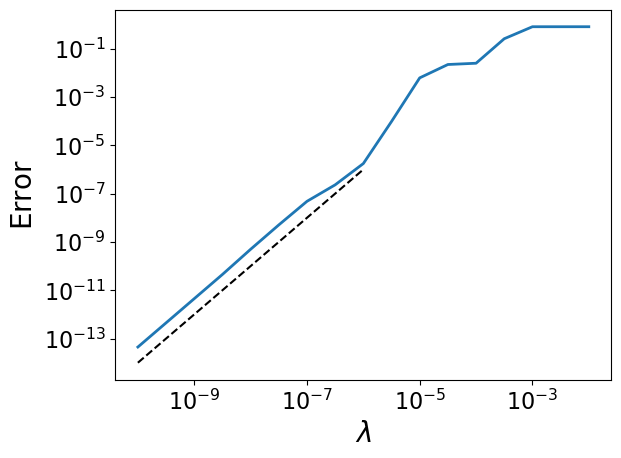

In [18]:
from scipy.stats.mstats import gmean
ids = ACostsTr[:,0,-1] < 1.e-10  # successfuly learned tasks
plot(Ls[1:], gmean(ACostsTr[ids,1:,-1], 0), lw=2)
plot(Ls[1:10], 1.e6*Ls[1:10]**2, 'k--')
xscale('log')
yscale('log')
xlabel(r'$\lambda$', size=20)
ylabel(r'$\rm{Error}$', size=20)
xticks(size=16)
yticks(size=16)

(array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

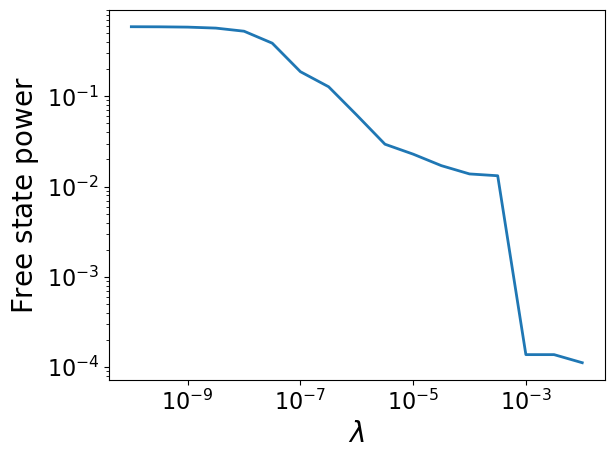

In [19]:
ids = ACostsTr[:,0,-1] < 1.e-10  # successfuly learned tasks
plot(Ls[1:], mean(APowersTr[ids,1:,-1], 0), lw=2)
xscale('log')
yscale('log')
xlabel(r'$\lambda$', size=20)
ylabel(r'$\rm{Free\ state\ power}$', size=20)
xticks(size=16)
yticks(size=16)